<a href="https://colab.research.google.com/github/robimalco/colab/blob/main/Home_Credit_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# START SETUP

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

In [ ]:
files.upload()

In [8]:
# !rm -rf kaggle*
# !rm -rf /root/.kaggle/
# !mkdir /root/.kaggle/
# !cp kaggle.json /root/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json
# !rm -rf sample_data

In [ ]:
!kaggle competitions download -c home-credit-default-risk

In [ ]:
!unzip application_test.csv.zip
!unzip application_train.csv.zip
# !unzip POS_CASH_balance.csv.zip
# !unzip bureau.csv.zip
# !unzip bureau_balance.csv.zip
# !unzip credit_card_balance.csv.zip
# !unzip installments_payments.csv.zip
# !unzip previous_application.csv.zip

In [ ]:
!rm -rf *.zip

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torchvision

In [12]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [14]:
pd.set_option('display.max_columns', None)

# Files

*   application_{train|test}.csv --> main table, static data for all applications. One row represents one loan in our data sample.
*   bureau.csv -->  client's previous credits, for every loan in our sample, there are as many rows as number of credits the client had.
*   bureau_balance.csv --> monthly balances of previous credits, one row for each month.
*   POS_CASH_balance.csv --> monthly balance snapshots of previous point of sales and cash loans that the applicant had, one row for each month.
*   credit_card_balance.csv --> monthly balance snapshots of previous credit cards, one row for each month.
*   previous_application.csv --> all previous applications for Home Credit loans of clients who have loans.
*   installments_payments.csv --> repayment history for the previously disbursed credits.

# Load all data into pandas dataframes

In [15]:
application_train_df = pd.read_csv('application_train.csv')
application_test_df = pd.read_csv('application_test.csv')
# bureau_df = pd.read_csv('bureau.csv')
# bureau_balance_df = pd.read_csv('bureau_balance.csv')
# pos_cash_balance_df = pd.read_csv('POS_CASH_balance.csv')
# credit_card_balance_df = pd.read_csv('credit_card_balance.csv')
# previous_application_df = pd.read_csv('previous_application.csv')
# installments_payments_df = pd.read_csv('installments_payments.csv')

In [17]:
application_train_df['CSV_SOURCE'] = 'application_train.csv'
application_test_df['CSV_SOURCE'] = 'application_test.csv'
temp_df = pd.concat([application_train_df, application_test_df])

In [186]:
rejected = application_train_df[application_train_df['TARGET'] == 0].shape[0]
approved = application_train_df[application_train_df['TARGET'] == 1].shape[0]
approval_rate = round(approved/(approved+rejected)*100)
print("approval_rate%", approval_rate)

approval_rate% 8


In [18]:
def split_columns_by_type(input_df):
  numerical_columns = []
  categorical_columns = []
  for column in application_train_df.columns:
    if application_train_df.dtypes[column] == np.int64 or application_train_df.dtypes[column] == np.float64:
      numerical_columns.append(column)
    else:
      categorical_columns.append(column)
  return numerical_columns, categorical_columns

# Function utilities

In [50]:
def smart_overview(input_df, numerical_columns):
  list_of_numerics = input_df.select_dtypes(include=['float', 'int']).columns
  countUnique = [len(input_df[column].unique()) for column in input_df.columns]
  corrSalePrice = round(input_df[numerical_columns].corrwith(input_df['TARGET']), 3)
  types = input_df.dtypes
  missing = round((input_df.isnull().sum()/input_df.shape[0]),3)*100
  overview = input_df.apply(
      lambda x: [
        round(x.min()), 
        round(x.max()), 
        round(x.mean()), 
        round(x.quantile(0.5))
      ] if x.name in list_of_numerics else x.unique())
  outliers = input_df.apply(
      lambda x: sum(
          (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)))) | 
          (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)))) 
        if x.name in list_of_numerics else ''))
  explore_df = pd.DataFrame({
    'Types': types,
    'Unique': countUnique,
    'CorrSalePrice': corrSalePrice,
    'Missing%': missing,
    'Overview': overview,
    'Outliers': outliers
  })
  explore_df['Types'] = explore_df['Types'].astype(str)
  return explore_df.transpose()

# Data Exploration

## application_{train|test}.csv

In [19]:
application_train_columns = list(application_train_df.columns)
application_train_columns.sort()
application_train_df = application_train_df[application_train_columns]

In [ ]:
temp_columns_type = split_columns_by_type(temp_df)
temp_numerical_columns = temp_columns_type[0]
temp_categorical_columns = temp_columns_type[1]
# smart_overview(application_train_df, temp_numerical_columns)

In [ ]:
temp_categorical_columns.remove('CSV_SOURCE')
temp_numerical_columns = ['AMT_ANNUITY', 'AMT_CREDIT']

for x in temp_categorical_columns:
  print('categorical', x, len(temp_df[x].unique()))

for x in temp_numerical_columns:
  print('numerical', x, len(temp_df[x].unique()))

In [56]:
pd.options.mode.chained_assignment = None
for column in temp_categorical_columns:
  temp_df[column] = LabelEncoder().fit_transform(temp_df[column].astype(str))
for column in temp_categorical_columns:
  temp_df[column] = temp_df[column].astype('category')

In [112]:
train_temp_df = temp_df[temp_df['CSV_SOURCE'] == 'application_train.csv']
train_output_temp_df = pd.DataFrame(train_temp_df['TARGET'], columns=['TARGET'])

test_temp_df = temp_df[temp_df['CSV_SOURCE'] == 'application_test.csv']

test_temp_df['AMT_ANNUITY'] = test_temp_df['AMT_ANNUITY'].fillna(0)

In [113]:
def create_categorical_tensor(input_df):
  stack = []
  for column in temp_categorical_columns:
    temp_stack = input_df[column].cat.codes.values
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)

def create_numerical_tensor(input_df):
  stack = []
  for column in temp_numerical_columns:
    temp_stack = input_df[column].astype(np.float64)
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)


tensor_train_categorical = create_categorical_tensor(train_temp_df[temp_categorical_columns]).float()
tensor_train_numerical = create_numerical_tensor(train_temp_df[temp_numerical_columns]).float()
tensor_train_output = torch.tensor(train_output_temp_df.values).flatten().float()

tensor_test_categorical = create_categorical_tensor(test_temp_df[temp_categorical_columns]).float()
tensor_test_numerical = create_numerical_tensor(test_temp_df[temp_numerical_columns]).float()

In [115]:
total_records_train = len(train_temp_df)
test_records_train = int(total_records_train * 0.2)

tensor_train_categorical_data = tensor_train_categorical[:total_records_train-test_records_train].to(device)
tensor_train_numerical_data = tensor_train_numerical[:total_records_train-test_records_train].to(device)
tensor_train_output = tensor_train_output[:total_records_train-test_records_train].to(device)

tensor_validation_categorical_data = tensor_train_categorical[total_records_train-test_records_train:total_records_train].to(device)
tensor_validation_numerical_data = tensor_train_numerical[total_records_train-test_records_train:total_records_train].to(device)
tensor_validation_output = tensor_train_output[:total_records_train-(total_records_train-test_records_train)].to(device)

In [116]:
categorical_columns_size = [len(temp_df[column].astype('category').cat.categories) for column in temp_categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_columns_size]
# categorical_embedding_sizes

In [117]:
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

train_data = TensorDataset(tensor_train_categorical_data, tensor_train_numerical_data, tensor_train_output)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

# print(torch.isnan(tensor_train_numerical_data))

In [196]:
class Model(nn.Module):
  def __init__(self, embedding_size, num_numerical_cols, layers, p=0.5):
    super().__init__()

    self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
    self.emb_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(num_numerical_cols)

    num_categorical_cols = sum((nf for ni, nf in embedding_size))
    input_size = num_categorical_cols + num_numerical_cols

    self.lin1 = nn.Linear(input_size, 200)
    self.lin2 = nn.Linear(200, 100)
    self.lin3 = nn.Linear(100, 50)
    self.lin4 = nn.Linear(50, 1)
    self.emb_drop = nn.Dropout(0.3)
    self.drops = nn.Dropout(0.1)

  def forward(self, x_categorical, x_numerical):

    embeddings = []
    for i,e in enumerate(self.all_embeddings):
        embeddings.append(e(x_categorical[:,i].long()))

    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)
    
    x_numerical = self.bn_cont(x_numerical)
    x = torch.cat([x, x_numerical], 1)

    x = self.lin1(x)
    x = self.drops(x)
    x = F.relu(self.lin2(x))
    x = self.drops(x)
    x = F.relu(self.lin3(x))
    x = self.drops(x)
    x = self.lin4(x)

    x = torch.sigmoid(x)

    return x

In [197]:
num_numerical_cols = tensor_train_numerical_data.shape[1]

model = Model(categorical_embedding_sizes, num_numerical_cols, [100, 50], 0.4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.to(device)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(3, 2)
    (2): Embedding(2, 1)
    (3): Embedding(2, 1)
    (4): Embedding(5, 3)
    (5): Embedding(4, 2)
    (6): Embedding(2, 1)
    (7): Embedding(5, 3)
    (8): Embedding(6, 3)
    (9): Embedding(6, 3)
    (10): Embedding(8, 4)
    (11): Embedding(8, 4)
    (12): Embedding(19, 10)
    (13): Embedding(58, 29)
    (14): Embedding(8, 4)
    (15): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.3, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=78, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=50, bias=True)
  (lin4): Linear(in_features=50, out_features=1, bias=True)
  (drops): Dropout(p=0.1, inplace=False)
)

In [198]:
n_epochs = 5

for epoch in range(n_epochs):
  for x_cat, x_num, y in train_loader:
    y_pred = model(x_cat, x_num)
    single_loss = loss_function(y_pred.squeeze(), y)
  print("epoch: " + str(epoch) + "\tloss: " + str(single_loss.item()))

epoch: 0	loss: 0.2648836672306061
epoch: 1	loss: 0.27769964933395386
epoch: 2	loss: 0.272550106048584
epoch: 3	loss: 0.27639901638031006
epoch: 4	loss: 0.2780704200267792


In [199]:
validation_data = TensorDataset(tensor_validation_categorical_data, tensor_validation_numerical_data, tensor_validation_output)
validation_loader = DataLoader(dataset=validation_data, batch_size=16, shuffle=True)

with torch.no_grad():
  for x_cat, x_num, y in validation_loader:
    y_valid = model(x_cat, x_num)
    validation_loss = loss_function(y_valid.squeeze(), y)
  print("\tvalidation_loss: " + str(validation_loss.item()))

	validation_loss: 0.2697506248950958


In [200]:
# Make predictions
with torch.no_grad():
  tensor_test_categorical_data = tensor_test_categorical.to(device)
  tensor_test_numerical_data = tensor_test_numerical.to(device)
  y_pred = model(tensor_test_categorical_data, tensor_test_numerical_data)

In [201]:
values, labels = torch.max(y_pred, 1)
labels.unique()

tensor([0], device='cuda:0')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd7c3187f0>]],
      dtype=object)

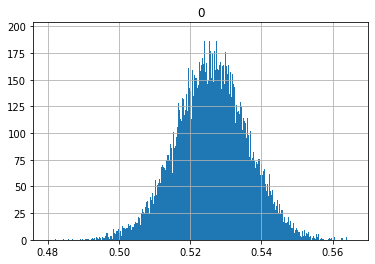

In [202]:
pd.DataFrame(y_pred).astype("float").hist(bins=1000)

In [240]:
temp = pd.DataFrame(y_pred).astype("float")

temp = pd.concat([temp, application_test_df['SK_ID_CURR']], axis=1)
temp.columns = ['TEMP_TARGET', 'SK_ID_CURR']
temp

,TEMP_TARGET,SK_ID_CURR
0,0.520464,100001
1,0.527660,100005
2,0.499079,100013
3,0.538143,100028
4,0.521120,100038
...,...,...
48739,0.522248,456221
48740,0.522126,456222
48741,0.508681,456223
48742,0.517821,456224


In [242]:
# range = temp['TARGET'].max() - temp['TARGET'].min()

# 0.089 : 100 = x : 50
# x = (50 * 0.089) / 100

#x = (50 * 0.08999999999) / 100


# (y - temp['TARGET'].min()) : x = (temp['TARGET'].max() - temp['TARGET'].min()) : 100

# x = ((y - temp['TARGET'].min()) * 100) / (temp['TARGET'].max() - temp['TARGET'].min())

# x = (100*y - 100*temp['TARGET'].min()) / (temp['TARGET'].max() - temp['TARGET'].min())

# x = (100*0.56 - 100*temp['TARGET'].min()) / (temp['TARGET'].max() - temp['TARGET'].min())


temp['TARGET'] = round((100*temp['TEMP_TARGET'] - 100*temp['TEMP_TARGET'].min()) / (temp['TEMP_TARGET'].max() - temp['TEMP_TARGET'].min()) / 100, 1)
temp

,TEMP_TARGET,SK_ID_CURR,TARGET
0,0.520464,100001,0.5
1,0.527660,100005,0.6
2,0.499079,100013,0.2
3,0.538143,100028,0.7
4,0.521120,100038,0.5
...,...,...,...
48739,0.522248,456221,0.5
48740,0.522126,456222,0.5
48741,0.508681,456223,0.3
48742,0.517821,456224,0.4


In [244]:
from google.colab import files

submission_df = temp[['SK_ID_CURR', 'TARGET']]
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>